# Numerical algorithms by examples

## Contents
   - [LU decomposition](#sec1)
   - [Jacobi method](#sec2)
   - [Gauss-Seidel method](#sec3)
   - [SOR method](#sec4)
   - [Thomas algorithm](#sec5)

In [1]:
import numpy as np
import scipy as scp
from scipy.linalg import solve_triangular
from FMNM.Solvers import Thomas

from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

The problem we want to solve in this notebook is very simple:
$$ A x = b$$
where A is a $n\times n$ square matrix and b is a vector of dimension $n$. **Our goal is to find the $x$!**

It is well known that the solution of this problem is simply:
$$ x = A^{-1} b $$
however, inverting a matrix is not (in general) a good idea.  
Matrix inversion is a slow operation and there are plenty of algorithms that permit to solve the matrix equation with no matrix inversion.

I will review the main methods by examples.   
Let us choose the following values of $A$,$x$ and $b$: 

Matrix A:


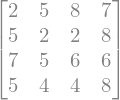

Vector x:


Vector b:


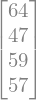

In [2]:
A = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])
x = np.array([[1], [2], [3], [4]])
b = A @ x
print("Matrix A:")
display_matrix(A)
print("Vector x:")
display_matrix(x)
print("Vector b:")
display_matrix(b)

The matrix A of this example is invertible!  
We can check it is a full rank matrix and calculate (just for curiosity) its determinant.

In [3]:
print("Rank:", np.linalg.matrix_rank(A))
print("Determinant:", np.linalg.det(A).round(2))

Rank: 4
Determinant: 194.0


The first method I'm presenting, is forbidden!!   
So... read it and then forget it.

The inverse of A is:


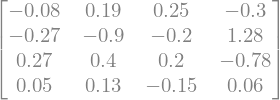

The value of x, given by matrix multiplication 'x = inv(A) @ b' is:


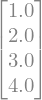

In [4]:
inv_A = scp.linalg.inv(A)
print("The inverse of A is:")
display_matrix(inv_A.round(2))
print("The value of x, given by matrix multiplication 'x = inv(A) @ b' is:")
display_matrix((inv_A @ b).round(2))

<a id='sec1'></a>
## LU decomposition

For more info about the theory of the LU decomposition, have a look at the wiki page [link](https://en.wikipedia.org/wiki/LU_decomposition)

Let us have a look at the LU decomposition.  
The matrix A is decomposed into the product of three matrices:
$$ A = P L U $$
where L and U are lower and upper triangular matrices, and P is a permutation matrix, which, reorders the rows of L@U. 

If you are not familiar with these concepts, they will be immediately clear after seeing them in practice.  
Scipy offers 3 modules:
- [scipy.linalg.lu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html)
- [scipy.linalg.lu_factor](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html)
- [scipy.linalg.lu_solve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html)

Lower triangular matrix:


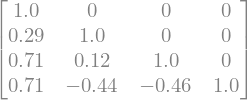

Upper triangular matrix:


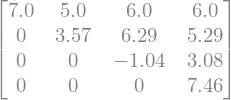

Permutation matrix:


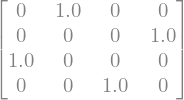

Have we obtained the correct decomposition? True


In [5]:
P, L, U = scp.linalg.lu(A)
print("Lower triangular matrix:")
display_matrix(L.round(2))
print("Upper triangular matrix:")
display_matrix(U.round(2))
print("Permutation matrix:")
display_matrix(P)
print("Have we obtained the correct decomposition?", np.allclose(P @ L @ U, A))

Ok... But what is the Permutation matrix?    
For more information on this subject have a look at the [wiki link](https://en.wikipedia.org/wiki/Permutation_matrix)

We can see that the product L@U is almost equal to A, but the rows have a different order.  For this reason we need to multiply it by P which produces the desired permutation.

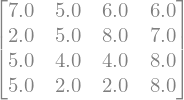

In [6]:
display_matrix(L @ U)

Let's have a deeper look.  
The coordinates of the ones in the matrix P indicate the relation between the rows of A and the rows of L@U:  
- (0,1) The first row of A corresponds to the second row of L@U; 
- (1,3) the second row of A correspond to the fourth of L@U; 
- (2,0) the third row of A corresponds to the first of L@U;
- (3,2) the fourth of A corresponds to the third of L@U.  

This is clear by looking at the columns of the matrix ```np.where(P==1)```.

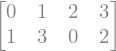

After the permutation the resulting matrix is equal to A:


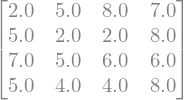

In [7]:
display_matrix(np.where(P == 1))
print("After the permutation the resulting matrix is equal to A:")
display_matrix((L @ U)[[1, 3, 0, 2]])

The previous code is useful to obtain the decomposition.  
Now we can solve the problem 

$$ PLU x = b $$

using both forward (for L) and backward (for U) substitution.  
Since permutation matrices are orthogonal matrices (i.e., $PP^T = I$) the inverse matrix exists and can be written as 
$$ P^{-1} = P^T $$
and there is no need to perform a matrix inversion.

The method **solve_triangular** performs the forward/backward substitution (it is a wrapper of the LAPACK function *trtrs*).  
We can write:

$$ L y = P^T b $$
and
$$ U x = y $$

and solve it:

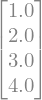

In [8]:
y = solve_triangular(L, P.T @ b, lower=True)
x_solution = solve_triangular(U, y)  # by default it considers upper triangular matricies as input
display_matrix(x_solution.round(2))

#### Another LU solver
A faster method to solve the linear equation using the LU decomposition is to use the **lu_factor** method (it is a wrapper of the LAPACK function getrf).   
It returns two matrices
- The first, LU,  is a matrix from which it is possible to derive easily the L and U matrices
- The second, piv, corrsponds to the pivot indices of the permutation matrix P:  
   In the matrix P, changing the row i with the row piv[i] (for all $0\leq i\leq 3$), produces the identity    matrix. The same permutation transforms A into L@U.  

Construction of the matrix L:


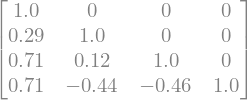

Construction of the matrix U:


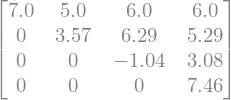

piv vector:


In [9]:
LU, piv = scp.linalg.lu_factor(A)
print("Construction of the matrix L:")
display_matrix((np.tril(LU, k=-1) + np.eye(4)).round(2))
print("Construction of the matrix U:")
display_matrix(np.triu(LU).round(2))
print("piv vector:")
display_matrix(piv)

Product of L@U:


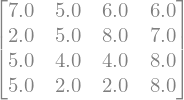

The matrix A after the permutations indicated by piv:


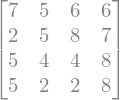

In [10]:
# Permutation of A in order to obtain L@U:
temp_A = list(A)
for i, j in enumerate(piv):
    temp_A[i], temp_A[j] = temp_A[j], temp_A[i]  # swap row i with row j=piv[i]

print("Product of L@U:")
display_matrix(L @ U)
print("The matrix A after the permutations indicated by piv:")
display_matrix(np.array(temp_A))

#### Solution

The solution of the linear system of equation can be obtained by feeding the output of lu_factor into the method **lu_solve** (which is a wrapper of the LAPACK function getrf).

The value of x is:


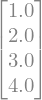

In [11]:
x = scp.linalg.lu_solve((LU, piv), b)
print("The value of x is:")
display_matrix(x.round(2))

<a id='sec2'></a>
## Jacobi method

This is an iterative method.   
The idea is to write the matrix $A = D + R$ as the sum of a diagonal matrix D and a "reminder" R (a matrix with only zeros in the diagonal).

$$ (D+R) x = b $$

$$ Dx = b - Rx$$

Using this idea, we can start with a guess solution $x^0$ and then iterate until $||x^{n+1}-x^n|| < \epsilon$.

$$ x^{n+1} = D^{-1} (b - Rx^{n})$$

The Jacobi and Gauss–Seidel methods converge if the matrix A is strictly diagonally dominant:

$$ |a_{i,i}| > \sum_{i \not= j} |a_{i,j}| $$
where $a_{i,j}$ are the entries of A.

For more info on the Jacobi method have a look at the wiki page [link](https://en.wikipedia.org/wiki/Jacobi_method).

#### New example:
Since the matrix A in the previous example is not diagonally dominant, let us define a new A, and therefore a new b as well. I like x=[1,2,3,4].

Matrix A with Rank:  4


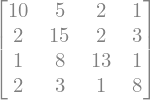

b:


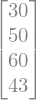

D:


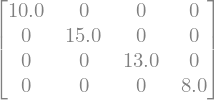

R:


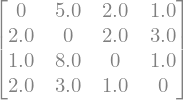

In [12]:
A = np.array([[10, 5, 2, 1], [2, 15, 2, 3], [1, 8, 13, 1], [2, 3, 1, 8]])
print("Matrix A with Rank: ", np.linalg.matrix_rank(A))
display_matrix(A)
x = np.array([[1], [2], [3], [4]])
print("b:")
b = A @ x
display_matrix(b)

D = np.eye(A.shape[0]) * np.diag(A)  # diagonal
D_inv = np.eye(A.shape[0]) * 1 / np.diag(A)  # inverse of D
R = A - D  # remainder
print("D:")
display_matrix(D)
print("R:")
display_matrix(R)

#### Comment
Notice that we do not need to invert the matrix D.  
Since D is a diagonal matrix, we can just invert the elements of the diagonal. This is a much more efficient method.

Convergence in 56 iterations:
x = 


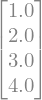

In [13]:
x0 = np.ones_like(b)  # initial guess
eps = 1e-10  # tolerance error
N_max = 100  # max number of iterations

for i in range(1, N_max + 1):
    x_new = D_inv @ (b - R @ x0)
    if scp.linalg.norm(x_new - x0) < eps:
        print("Convergence in {} iterations:".format(i))
        break
    x0 = x_new
    if i == N_max:
        print("Fail to converge in {} iterations".format(i))
print("x = ")
display_matrix(x_new.round(2))

<a id='sec3'></a>
## Gauss-Seidel method

This method is very similar to the Jacobi method. It is again an iterative method.   
The idea is to write the matrix $A = L + U$ as the sum of a lower triangular matrix L and a strictly upper triangular matrix U.

$$ (L+U) x = b $$

$$ Lx = b - Ux$$

Like in the Jacobi method we look for an approximate solution $x^{n+1}$, and iterate until $||x^{n+1}-x^n|| < \epsilon$.

$$ x^{n+1} = L^{-1} (b - Ux^{n})$$

Again, given the specific form of the matrices L and U, we don't need to invert any matrix.  
We will just use the forward substitution.

For more info on the Gauss-Seidel method have a look at the wiki page [link](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method).

Let us consider the same A,x,b as in the previous example:

In [14]:
U = np.triu(A, k=1)  # Matrix U
L = np.tril(A)  # Matrix L

Convergence in 15 iterations:
x = 


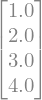

In [15]:
x0 = np.ones_like(b)  # initial guess
eps = 1e-10  # tolerance error
N_max = 100  # max number of iterations

for i in range(1, N_max + 1):
    x_new = solve_triangular(L, (b - U @ x0), lower=True)
    if scp.linalg.norm(x_new - x0) < eps:
        print("Convergence in {} iterations:".format(i))
        break
    x0 = x_new
    if i == N_max:
        print("Fail to converge in {} iterations".format(i))
print("x = ")
display_matrix(x_new.round(2))

#### Comment:
The Gauss-Seidel algorithm converges much faster than the Jacobi method (15 iterations agains 56).

<a id='sec4'></a>
## SOR (successive over-relaxation) 


This is another improvement of the previous methods.   
Let's write the matrix $A = L + U + D$ as the sum of a strictly lower triangular matrix L, a strictly upper triangular matrix U and a diagonal matrix D.

$$ (L+U+D) x = b $$

$$ w (L+U+D) x = w b $$

$$ w L x = w b - w D x - w U x \pm D x $$

$$ (w L + D) x = w b - \bigl( w U + (w - 1) D \bigr)  x $$

As in the previous methods, given the specific form of the matrices, we don't need to invert any matrix.  The iterative method is the following:

$$ x^{n+1} = (w L + D)^{-1} \biggl( w b - \bigl( w U + (w - 1) D \bigr)  x^n \biggr) $$

For more info on the SOR method have a look at the wiki page [link](https://en.wikipedia.org/wiki/Successive_over-relaxation).

In [16]:
D = np.eye(A.shape[0]) * np.diag(A)  # diagonal
U = np.triu(A, k=1)  # Strict U
L = np.tril(A, k=-1)  # Strict L

Convergence in 34 iterations:
x = 


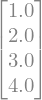

In [17]:
x0 = np.ones_like(b)  # initial guess
eps = 1e-10  # tolerance error
N_max = 100  # max number of iterations
w = 1.4  # relaxation factor

for i in range(1, N_max + 1):
    x_new = solve_triangular((w * L + D), (w * b - w * U @ x0 - (w - 1) * D @ x0), lower=True)
    if scp.linalg.norm(x_new - x0) < eps:
        print("Convergence in {} iterations:".format(i))
        break
    x0 = x_new
    if i == N_max:
        print("Fail to converge in {} iterations".format(i))
print("x = ")
display_matrix(x_new.round(2))

By changing the *relaxation parameter* we can see how the number of iterations changes.  
The relaxation must satisfy $0<w<2$.  
It seems that in this case the optimal value of $w$ is 1 and the minimum number of iterations is 15.  
The Gauss-Seidel algorithm is a special case of the SOR algorithm, with w=1!

<a id='sec5'></a>
## Thomas algorithm

The Thomas algorithm is a simplified form of Gaussian elimination that is used to solve tridiagonal systems of equations.   
Have a look at the wiki page: [TDMA](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)

The idea is simply to transform the matrix A into a triagonal matrix and then use backward substitution.

Here we consider the single coefficients of the linear system instead of performing matrix operations like in the previous algorithms.  

$$ a_i x_{i-1} + b_i x_{i} + c_i x_{i+1} = d_i $$

The algorithm we implement is the following (taken from wikipedia):

$$ w_i = \frac{a_i}{b_{i-1}} $$

$$ b_i = b_i - w_i c_{i-1} $$

$$ d_i = d_i - w_i d_{i-1} $$

and then we perform backward substitution:

$$ x_n = \frac{d_n}{b_n} $$

$$ x_i = \frac{d_i - c_i x_{i+1}}{b_i} $$

Let us introduce a new matrix A wich is tridiagonal. Of course we like to keep the ```x = [1,2,3,4]``` 

Matrix A with Rank:  4


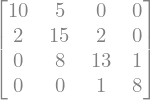

b:


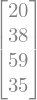

In [18]:
A = np.array([[10, 5, 0, 0], [2, 15, 2, 0], [0, 8, 13, 1], [0, 0, 1, 8]])
print("Matrix A with Rank: ", np.linalg.matrix_rank(A))
display_matrix(A)
print("b:")
x = np.array([[1], [2], [3], [4]])
b = A @ x
display_matrix(b)

In [19]:
## TDMA:  Tri-Diagonal-Matrix-Algorithm solver
def TDMA(A, B):
    N = len(B)  # number of equations
    a = A.diagonal(offset=-1).copy()  # need to copy because the array is not writable
    b = A.diagonal(offset=0).copy()  # see A.diagonal(offset=0).flags
    c = A.diagonal(offset=1).copy()
    d = B.copy()
    x = np.ones_like(d)  # initialize x

    # Overwright coefficients
    for i in range(1, N):
        w = a[i - 1] / b[i - 1]
        b[i] = b[i] - w * c[i - 1]
        d[i] = d[i] - w * d[i - 1]

    # backward substitution
    x[-1] = d[-1] / b[-1]
    for i in range(N - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]

    return x

In [20]:
x_sol = TDMA(A, b)
print("x= ")
display_matrix(x_sol)

x= 


#### Ok, I know the previous code is not very efficient! 
I just wanted to prove that the algorithms work. 

In order to show how slow is python code compared to routines that call optimized C/fortran, I wrote a wrapper for the LAPACK function **dgtsv** which implements the Thomas algorithm. I called this function *"Thomas"*.  
You can see that it is about **8 times much faster** than the function I wrote above.

On this topic, I wrote an entire notebook about code optimization and speed up. (notebook **A2**)

Solution of Ax=b with the LAPACK function dgtsv. 
 x= 


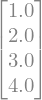

In [21]:
print("Solution of Ax=b with the LAPACK function dgtsv. \n x= ")
display_matrix(Thomas(A, b))

In [22]:
%%timeit
TDMA(A, b)

15.2 µs ± 188 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
%%timeit
Thomas(A, b)

1.4 µs ± 4.48 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
